# **<font color="#FBBF44">Imports</font>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#!pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

# **<font color="#FBBF44">Functions</font>**

In [2]:
# Time limits for different sets of instances
timelimCHU = 1200
timelimCE = 3600
timelimG = 7200

# Cost factors for large and Small vehicles
a1 = np.random.randint(5,10)/10 # = .8
a2 = a1*.75 # = .6

# Instance generator
def instance_gen(seed, clients, S1, S2, Q1, dmin, dmax):
    np.random.seed(seed) # Initial seed
    n = clients # number of clients
    # random location of clients within 8km radius
    xc = np.random.rand(n+1)*8 
    yc = np.random.rand(n+1)*8
    points = range(0,n+1)

    N = [i for i in range(1, n + 1)] # Set of clients
    V = [0] + N # Set of all nodes, including depot
    A = [(i,j) for i in V for j in V if i != j] # Available arcs between nodes
    
    S = S1 + S2 # Total amount of available vehicles
    K = [i for i in range(1, S + 1)] # Number of available vehicles, including large and small
    K1 = [i for i in range(1, S1 + 1)] # subset of large vehicles
    K2 = [i for i in range(S1+1, S1+S2+1)] # subset of small vehicles
    
    Ak = [(i,j,k) for k in K for i in V for j in V if i != j] # Available arcs between nodes for each vehicle
    Q = {} # Capacities
    for i in K:
        if i in K1:
            Q[i] = Q1 
        else:
            Q[i] = Q1/2

    d = {i: np.random.randint(dmin, dmax) for i in N} # Random demands from customers

    a1 = .8
    a2 = .6

    d1 = {(i,j,1): (np.hypot(xc[i] - xc[j], yc[i] - yc[j])) + np.random.rand() for i, j in A}
    d2 = {(i,j,2): d1[i,j,1] for i, j in A}
    c1 = {k:v*a1 for k, v in d1.items()} # Cost for traversing i,j with LargeVehicle
    c2 = {k:v*a2 for k, v in d2.items()} # Cost for traversing i,j with SmallVehicle
    c = dict(c1)
    c.update(c2) 
    return n, xc, yc, points, list(N), V, K, K1, K2, A, Ak, S, Q, d, c

In [3]:
# Building the model
def build_model():
    model = gp.Model(name)
    x = model.addVars(A, K, vtype=GRB.BINARY) # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
    y = model.addVars(N, K, vtype=GRB.INTEGER) # y[i,k] = amount delivered to client i by vehicle k 
    u = model.addVars(N, K, vtype=GRB.INTEGER) # u[i,k] = support variable for MTZ constraints
    z = model.addVars(N, K, vtype=GRB.BINARY) # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
    M = 1000000000 # Big M

    # objective
    model.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2), GRB.MINIMIZE)
    # (1)
    model.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
    # (2)
    model.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
    # (3)
    model.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
    # (4)
    model.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
    # (5)
    model.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
    # (6)
    model.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
    # (7)
    model.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
    # (8)
    model.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
    model.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)
    
    return model, x

In [4]:
# Plotting solution
def plot_sol(xc, yc, K1, K2, active_arcs, name):
    colors = []
    for i in range(len(active_arcs)):
        colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))

    plt.plot(xc[0], yc[0], c='red', marker='s', label="Depot")
    plt.scatter(xc[1:], yc[1:], label="Clients")
#     for i in range(len(xc)):
#         plt.annotate(points[i], (xc[i] - .5, yc[i] + 0.4))
    
    for k in K1:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k], lw=1.5, mutation_scale=15))
    for k in K2:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k], lw=1.5, mutation_scale=15))

    plt.xlim((-0.5, 8.5))
    plt.ylim((-0.5, 8.5))
    handles, labels = plt.gca().get_legend_handles_labels()
    lines = {}
    K = K1 + K2
    for k in K:
        if k in K1:
            lines[k] = Line2D([0], [0], label='LargeVehicle {}'.format(k), color = colors[k]) #, color='teal')
        else:
            lines[k] = Line2D([0], [0], label='SmallVehicle {}'.format(k), color = colors[k]) #, color='teal')

    handles.extend(lines.values())

    plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
    plt.title("Optimal routes for {}".format(name))
    #plt.savefig("FigXX-Tour{}".format(name)+".png", bbox_inches='tight', dpi=600) 
    plt.show()

In [5]:
# Finding the edges from solution values, as a tuplelist for each k
def selected(vals):
    s = {k:gp.tuplelist() for k in K}
    for i, j, k in vals.keys():
        if vals[i,j,k] > 0.99:
            s[k].append((i,j))
    return s
       
# Given the edges, finding the optimal route for each k
def subtour(edges):
    nodes = set(i for e in edges for i in e)
    unvisited = list(nodes)
    cycle = list(nodes)
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle): # even if it's the same, we reuse it so that we get the final tour in order
            cycle = thiscycle # New shortest subtour
    return cycle

# Print each tour
def print_route(objective, edges):
    print(f"The optimal cost for the distance traveled is: {(round(objective,2))} €")
    for k in K:
        tour = subtour(edges[k])
        tour.append(0) # return to depot
        print ("Route for vehicle k%i: %s" % (k, " -> ".join(map(str, tour))))

# **<font color="#BBBF">CHU INSTANCES</font>**

In [6]:
times = []
objectives = []

## **<font color="#FBBF44">CHU-01</font>**

Discarded solution information
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 131 rows, 90 columns and 440 nonzeros
Model fingerprint: 0x9736c319
Variable types: 0 continuous, 90 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 45 rows and 5 columns
Presolve time: 0.00s
Presolved: 86 rows, 85 columns, 380 nonzeros
Variable types: 0 continuous, 85 integer (70 binary)

Root relaxation: objective 1.894150e+01, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

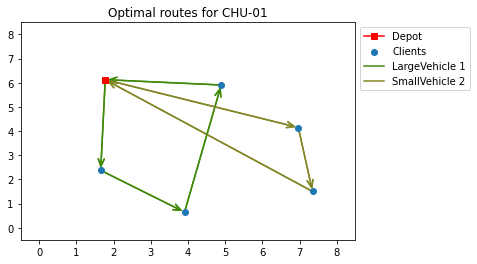

The optimal cost for the distance traveled is: 22.56 €
Route for vehicle k1: 0 -> 2 -> 4 -> 5 -> 0
Route for vehicle k2: 0 -> 1 -> 3 -> 0
Time to best solution = 0.044879913330078125


In [32]:
############ Instance Initialization CHU-01 ############
name = "CHU-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=5,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=30,
                                                                     dmin=7,
                                                                     dmax=10)
############ model1 Construction ############
model1, x = build_model()

############ model1 Solving ############
model1.reset()
model1.Params.TimeLimit = timelimCHU  # Time limit
model1.optimize()

############ Plotting Solution ############
if model1.solcount >= 1:
    #model1.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model1.getAttr('X', x)
    print_route(objective=model1.objVal, edges=selected(vals))
    print(f"Time to best solution = {model1.runtime}")
    times.append(model1.runtime)
    objectives.append(model1.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-02</font>**

Discarded solution information
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 456 rows, 280 columns and 1680 nonzeros
Model fingerprint: 0xa0005e19
Variable types: 0 continuous, 280 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [9e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 190 rows and 10 columns
Presolve time: 0.00s
Presolved: 266 rows, 270 columns, 1460 nonzeros
Variable types: 0 continuous, 270 integer (240 binary)

Root relaxation: objective 2.023748e+01, 105 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

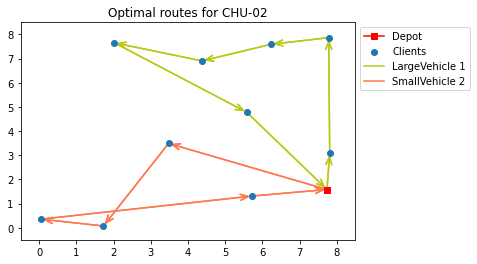

The optimal cost for the distance traveled is: 29.2 €
Route for vehicle k1: 0 -> 6 -> 2 -> 10 -> 1 -> 8 -> 4 -> 0
Route for vehicle k2: 0 -> 9 -> 5 -> 7 -> 3 -> 0
Time to best solution = 0.26923370361328125


In [33]:
############ Instance Initialization CHU-02 ############
name = "CHU-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=10,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model2 Construction ############
model2, x = build_model()

############ model2 Solving ############
model2.reset()
model2.Params.TimeLimit = timelimCHU  # Time limit
model2.optimize()

############ Plotting Solution ############
if model2.solcount >= 1:
    # model2.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model2.getAttr('X', x)
    print_route(objective=model2.objVal, edges=selected(vals))
    times.append(model2.runtime)
    print(f"Time to best solution = {model2.runtime}")
    objectives.append(model2.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-03</font>**

Discarded solution information
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1464 rows, 855 columns and 5580 nonzeros
Model fingerprint: 0x4a3fb84e
Variable types: 0 continuous, 855 integer (765 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [6e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 630 rows and 0 columns
Presolve time: 0.01s
Presolved: 834 rows, 855 columns, 4905 nonzeros
Variable types: 0 continuous, 855 integer (765 binary)

Root relaxation: objective 2.725289e+01, 243 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

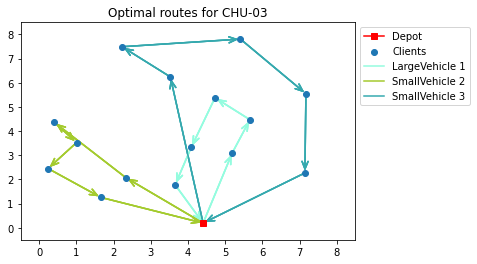

The optimal cost for the distance traveled is: 33.24 €
Route for vehicle k1: 0 -> 12 -> 1 -> 15 -> 3 -> 11 -> 0
Route for vehicle k2: 0 -> 2 -> 8 -> 6 -> 10 -> 7 -> 0
Route for vehicle k3: 0 -> 9 -> 13 -> 14 -> 5 -> 4 -> 0
Time to best solution = 9.70832633972168


In [34]:
############ Instance Initialization CHU-03 ############
name = "CHU-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=15,
                                                                     S1=1,
                                                                     S2=2,
                                                                     Q1=80,
                                                                     dmin=7,
                                                                     dmax=10)
############ model3 Construction ############
model3, x = build_model()

############ model3 Solving ############
model3.reset()
model3.Params.TimeLimit = timelimCHU  # Time limit
model3.optimize()

############ Plotting Solution ############
if model3.solcount >= 1:
    # model3.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model3.getAttr('X', x)
    print_route(objective=model3.objVal, edges=selected(vals))
    times.append(model3.runtime)
    print(f"Time to best solution = {model3.runtime}")
    objectives.append(model3.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-04</font>**

Discarded solution information
Set parameter TimeLimit to value 1200
Set parameter MIPGap to value 0.15
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3396 rows, 1920 columns and 13280 nonzeros
Model fingerprint: 0xd09f7f3e
Variable types: 0 continuous, 1920 integer (1760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1524 rows and 0 columns
Presolve time: 0.03s
Presolved: 1872 rows, 1920 columns, 10000 nonzeros
Variable types: 0 continuous, 1920 integer (1760 binary)
Found heuristic solution: objective 124.8183372

Root relaxation: objective 2.409883e+01, 523 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |  

 144907 89107   30.27740   61  189   35.86490   29.76940  17.0%  31.7  180s
 148626 91846   30.93196   62  106   35.86490   29.78931  16.9%  31.8  185s
 152549 94763   35.35002  112  142   35.86490   29.80205  16.9%  32.0  191s
 155946 97346   33.84059   83  155   35.86490   29.81995  16.9%  32.1  195s
 159278 100022   32.69286   92  125   35.86490   29.83412  16.8%  32.2  201s
 162705 102223   35.57932   91   70   35.86490   29.84630  16.8%  32.3  205s
 166664 105053   33.65004  111  137   35.86490   29.86360  16.7%  32.6  210s
 170056 107548   31.79881   68  111   35.86490   29.87731  16.7%  32.7  215s
 173085 109628   31.98072   88  191   35.86490   29.88879  16.7%  32.8  220s
 177176 112582   31.82809   65  152   35.86490   29.90752  16.6%  32.9  225s
 180958 115272   34.01320  109  168   35.86490   29.92042  16.6%  33.0  231s
 184272 117744   31.04784   68  115   35.86490   29.93055  16.5%  33.1  235s
 188281 120299   33.51571   69   60   35.86490   29.94501  16.5%  33.3  241s
 19

  Clique: 7
  MIR: 479
  StrongCG: 34
  Flow cover: 901
  GUB cover: 1
  Inf proof: 129
  Zero half: 55
  RLT: 26
  Relax-and-lift: 32

Explored 430645 nodes (16570822 simplex iterations) in 680.08 seconds (895.36 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 35.8649 35.8649 35.8649 ... 36.1708

Optimal solution found (tolerance 1.50e-01)
Best objective 3.586490413033e+01, best bound 3.048593922479e+01, gap 14.9979%


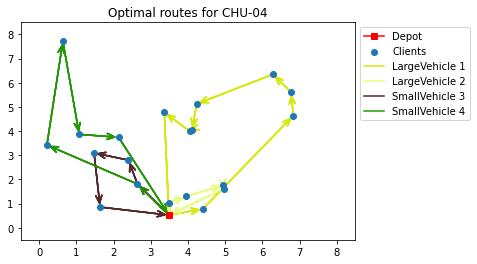

The optimal cost for the distance traveled is: 35.86 €
Route for vehicle k1: 0 -> 2 -> 16 -> 18 -> 15 -> 11 -> 13 -> 20 -> 4 -> 0
Route for vehicle k2: 0 -> 3 -> 17 -> 7 -> 10 -> 0
Route for vehicle k3: 0 -> 5 -> 8 -> 14 -> 6 -> 0
Route for vehicle k4: 0 -> 5 -> 1 -> 19 -> 12 -> 9 -> 0
Time to best solution = 680.0794353485107


In [19]:
############ Instance Initialization CHU-04 ############
name = "CHU-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=20,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=70,
                                                                     dmin=7,
                                                                     dmax=10)
############ model4 Construction ############
model4, x = build_model()

############ model4 Solving ############
model4.reset()
model4.Params.TimeLimit = timelimCHU  # Time limit
model4.Params.MIPGap = .15
model4.optimize()

############ Plotting Solution ############
if model4.solcount >= 1:
    # model4.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model4.getAttr('X', x)
    print_route(objective=model4.objVal, edges=selected(vals))
    times.append(model4.runtime)
    print(f"Time to best solution = {model4.runtime}")
    objectives.append(model4.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CHU-05</font>**

Discarded solution information
Set parameter TimeLimit to value 1200
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6545 rows, 3625 columns and 25750 nonzeros
Model fingerprint: 0x5b72127b
Variable types: 0 continuous, 3625 integer (3375 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3005 rows and 0 columns
Presolve time: 0.19s
Presolved: 3540 rows, 3625 columns, 19375 nonzeros
Variable types: 0 continuous, 3625 integer (3375 binary)
Found heuristic solution: objective 187.6877317

Root relaxation: objective 3.789698e+01, 749 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |  

  8557  6154   43.15495   49  202   49.56016   42.01142  15.2%  38.2  175s
  9241  6549   46.35783   48  212   49.56016   42.06631  15.1%  38.3  180s
  9893  7225   47.89641   62  191   49.56016   42.08352  15.1%  38.4  187s
 10266  7565   47.96523   55  138   49.56016   42.09323  15.1%  38.4  191s
 10753  7817   42.96556   49  246   49.56016   42.10861  15.0%  38.4  195s
 11416  8294   47.03112   58   63   49.56016   42.11499  15.0%  39.1  201s
 11755  8549   46.87878   88  131   49.56016   42.11499  15.0%  39.5  206s
 12456  9144     cutoff  154        49.56016   42.13115  15.0%  40.2  213s
 12913  9462   43.81655   41  241   49.56016   42.14232  15.0%  40.3  217s
 13355  9834   46.33640   45  182   49.56016   42.14616  15.0%  40.6  221s
 13882 10177   45.69414   46  232   49.56016   42.16397  14.9%  40.7  226s
 14294 10725   42.50790   41  234   49.56016   42.16446  14.9%  40.5  231s
 14961 11237   48.10815  111  135   49.56016   42.17638  14.9%  40.2  238s
 15648 11342   45.68515  

 58276 34862   44.16807   57  153   49.56016   42.66714  13.9%  49.9  901s
 59113 35158   46.52585   77  256   49.56016   42.67677  13.9%  50.1  911s
 59867 35613   43.85447   78  261   49.56016   42.69403  13.9%  50.2  924s
 60774 36171   46.09259  129  288   49.56016   42.70184  13.8%  50.2  934s
 61841 36423     cutoff   71        49.56016   42.71439  13.8%  50.3  942s
 62712 36702   43.00502   58  312   49.56016   42.72835  13.8%  50.4  951s
 63476 37062   47.94772   64  212   49.56016   42.73886  13.8%  50.4  959s
 64430 37178   46.94434   76  204   49.56016   42.74532  13.8%  50.4  968s
 65101 37576   43.48706   63  281   49.56016   42.75832  13.7%  50.6  976s
 65920 37829   48.47431   94  158   49.56016   42.77137  13.7%  50.7  983s
 66576 38339   45.03404   74  128   49.56016   42.78032  13.7%  50.8  992s
 67510 38663   46.53628   83  164   49.56016   42.79224  13.7%  50.8  999s
 68309 39021   47.78927   92  182   49.56016   42.79928  13.6%  50.9 1008s
 69111 39380   48.06047  

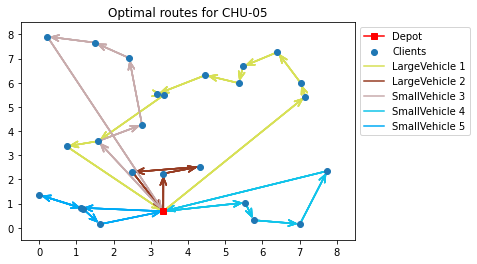

The optimal cost for the distance traveled is: 49.56 €
Route for vehicle k1: 0 -> 25 -> 13 -> 20 -> 11 -> 15 -> 17 -> 8 -> 10 -> 19 -> 5 -> 0
Route for vehicle k2: 0 -> 16 -> 9 -> 22 -> 0
Route for vehicle k3: 0 -> 19 -> 7 -> 3 -> 6 -> 14 -> 0
Route for vehicle k4: 0 -> 23 -> 1 -> 24 -> 21 -> 0
Route for vehicle k5: 0 -> 18 -> 2 -> 4 -> 12 -> 0
Time to best solution = 1200.2026767730713


In [37]:
############ Instance Initialization CHU-05 ############
name = "CHU-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=25,
                                                                     S1=2,
                                                                     S2=3,
                                                                     Q1=75,
                                                                     dmin=7,
                                                                     dmax=10)
############ model5 Construction ############
model5, x = build_model()

############ model5 Solving ############
model5.reset()
model5.Params.TimeLimit = timelimCHU  # Time limit
model5.Params.MIPGap = .05
model5.optimize()

############ Plotting Solution ############
if model5.solcount >= 1:
    # model5.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model5.getAttr('X', x)
    print_route(objective=model5.objVal, edges=selected(vals))
    times.append(model5.runtime)
    print(f"Time to best solution = {model5.runtime}")
    objectives.append(model5.objVal)
else:
    print("No feasible solution found")

# **<font color="#BBBF">CE INSTANCES</font>**

## **<font color="#FBBF44">CE-01</font>**

Discarded solution information
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6608 rows, 3520 columns and 26080 nonzeros
Model fingerprint: 0x97b825e0
Variable types: 0 continuous, 3520 integer (3360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3162 rows and 40 columns
Presolve time: 0.05s
Presolved: 3446 rows, 3480 columns, 19520 nonzeros
Variable types: 0 continuous, 3480 integer (3360 binary)

Root relaxation: objective 3.675523e+01, 612 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexp

 77414 24967   42.24032   43  269   43.31822   41.50034  4.20%  43.9  255s
 79972 26098   41.91789   36  285   43.31822   41.52271  4.14%  44.3  260s
 81242 26519   42.06740   58  312   43.31822   41.53246  4.12%  44.6  265s
 81250 26524   41.86282   36  323   43.31822   41.53246  4.12%  44.5  270s
 81256 26528   42.56925   78  323   43.31822   41.53246  4.12%  44.5  275s
 81259 26533   41.53246   37  318   43.31822   41.53246  4.12%  44.6  280s
 81388 26617   41.53246   56   80   43.31822   41.53246  4.12%  44.6  285s
H81542 25321                      43.2881145   41.53246  4.06%  44.6  286s
H82242 24337                      43.2121936   41.53246  3.89%  44.7  289s
 82603 24475   42.45189   64  145   43.21219   41.53246  3.89%  44.7  290s
 84756 25192   43.12680   64  155   43.21219   41.53246  3.89%  44.9  295s
 87403 25784   42.58906   51  230   43.21219   41.53246  3.89%  45.2  300s
 90278 26358   42.28184   75   89   43.21219   41.53246  3.89%  45.5  305s
 92674 26882   41.60890  

  Clique: 10
  MIR: 119
  StrongCG: 4
  Flow cover: 347
  GUB cover: 1
  Inf proof: 25
  Zero half: 83
  RLT: 3
  Relax-and-lift: 10

Explored 344259 nodes (18008124 simplex iterations) in 771.60 seconds (1826.45 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 42.8684 43.2122 43.2881 ... 46.3738

Optimal solution found (tolerance 1.00e-02)
Best objective 4.286844688598e+01, best bound 4.243979460521e+01, gap 0.9999%


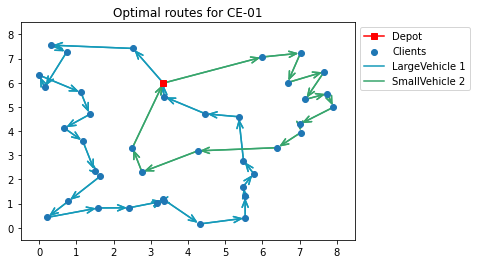

The optimal cost for the distance traveled is: 42.87 €
Route for vehicle k1: 0 -> 35 -> 27 -> 5 -> 38 -> 2 -> 18 -> 28 -> 26 -> 4 -> 6 -> 12 -> 30 -> 14 -> 19 -> 3 -> 31 -> 8 -> 16 -> 9 -> 23 -> 34 -> 11 -> 1 -> 36 -> 15 -> 17 -> 10 -> 0
Route for vehicle k2: 0 -> 39 -> 29 -> 37 -> 32 -> 25 -> 21 -> 40 -> 24 -> 13 -> 20 -> 33 -> 7 -> 22 -> 0
Time to best solution = 771.6032619476318


In [21]:
############ Instance Initialization CE-01 ############
name = "CE-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=40,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=400,
                                                                     dmin=12,
                                                                     dmax=15)
############ model6 Construction ############
model6, x = build_model()

############ model6 Solving ############
model6.reset()
model6.Params.TimeLimit = timelimCE  # Time limit
model6.Params.MIPGap = .01
model6.optimize()

############ Plotting Solution ############
if model6.solcount >= 1:
    # model6.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model6.getAttr('X', x)
    print_route(objective=model6.objVal, edges=selected(vals))
    times.append(model6.runtime)
    print(f"Time to best solution = {model6.runtime}")
    objectives.append(model6.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-02</font>**

Discarded solution information
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.15
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 30674 rows, 16200 columns and 121800 nonzeros
Model fingerprint: 0xa3eb4fbe
Variable types: 0 continuous, 16200 integer (15600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 14706 rows and 0 columns
Presolve time: 0.21s
Presolved: 15968 rows, 16200 columns, 91500 nonzeros
Variable types: 0 continuous, 16200 integer (15600 binary)
Found heuristic solution: objective 289.1116566

Root relaxation: objective 4.564073e+01, 2020 iterations, 0.15 seconds (0.26 work units)

    Nodes    |    Current 

  2640  1149   52.18205   28  515   80.99826   51.03347  37.0%  46.2  130s
H 2695  1124                      80.6276568   51.03347  36.7%  50.4  133s
  2716  1144   51.42413   34  343   80.62766   51.03347  36.7%  51.5  135s
  2769  1184   51.75708   41  435   80.62766   51.03347  36.7%  55.9  140s
H 2798  1146                      80.5216885   51.03347  36.6%  57.2  141s
  2847  1189   52.63764   47  420   80.52169   51.03347  36.6%  59.3  145s
  2948  1264   53.00694   53  383   80.52169   51.03347  36.6%  62.6  150s
H 2951  1212                      80.1624148   51.03347  36.3%  62.7  150s
  3093  1298   53.08537   61  433   80.16241   51.03347  36.3%  64.7  155s
  3240  1413   54.76859   70  312   80.16241   51.03347  36.3%  68.1  160s
H 3320  1385                      79.7921838   51.03347  36.0%  69.3  162s
  3471  1508   57.59215   86  270   79.79218   51.03347  36.0%  70.0  166s
  3726  1627   61.90058  113  193   79.79218   51.03347  36.0%  70.5  171s
  3845  1768   65.07815  

 20957 11120   51.56334   33 1129   75.86394   51.37397  32.3%  89.7  865s
 20959 11122   58.73573  133 1039   75.86394   51.37397  32.3%  89.7  872s
 20960 11122   58.40536  141  975   75.86394   51.37397  32.3%  89.7  876s
 20962 11124   52.83613   49  827   75.86394   51.37397  32.3%  89.7  883s
 20963 11124   57.69027   89  888   75.86394   51.37397  32.3%  89.7  887s
 20964 11125   53.05780   77  854   75.86394   51.37397  32.3%  89.7  891s
H20965 10569                      75.5578346   51.37397  32.0%  89.7  898s
 20967 10570   56.49971   90  980   75.55783   51.37397  32.0%  89.7  902s
 20968 10571   60.35276  105  857   75.55783   51.37397  32.0%  89.7  906s
 20970 10572   61.44389  182  889   75.55783   51.37397  32.0%  89.7  917s
 20971 10573   58.43577  152  889   75.55783   51.37397  32.0%  89.7  920s
 20972 10573   51.64347   33  889   75.55783   51.37397  32.0%  89.7  926s
 20973 10577   51.37397   34  879   75.55783   51.37397  32.0%  90.8  936s
 20975 10580   51.37397  

 46709 24362   69.99982 1477  376   75.19837   51.62792  31.3%  84.3 1685s
 46890 24616   51.88199   46  963   75.19837   51.62792  31.3%  84.4 1693s
 47226 24698   53.14815   63  752   75.19837   51.62792  31.3%  84.5 1699s
 47353 24867   53.97489   78  550   75.19837   51.62792  31.3%  84.7 1706s
 47523 25288   55.00162  167  317   75.19837   51.62792  31.3%  84.9 1714s
 47945 25620   55.96906  495  343   75.19837   51.62792  31.3%  84.7 1723s
 48277 25914   56.24749  727  409   75.19837   51.62792  31.3%  84.6 1731s
 48578 26566   62.70509  884  223   75.19837   51.62792  31.3%  84.7 1740s
 49233 26899   64.56979 1377  235   75.19837   51.63775  31.3%  84.2 1749s
 49631 27165   52.96348   53  483   75.19837   51.63775  31.3%  84.1 1756s
 49907 27551   57.90478  101  329   75.19837   51.64046  31.3%  84.3 1764s
 50345 27874   52.49403   47  921   75.19837   51.64046  31.3%  84.2 1772s
 50689 28040   54.91436   72  737   75.19837   51.64046  31.3%  84.2 1779s
 50873 28424   56.37607  

 88663 64546   70.28347 1424  328   74.84176   51.75042  30.9%  77.0 2706s
 89330 64850   53.93721   56  766   74.84176   51.75042  30.9%  76.8 2714s
 89651 64990   54.78071   71  723   74.84176   51.75042  30.9%  76.7 2721s
 89806 65253   60.06590  109  399   74.84176   51.75042  30.9%  76.9 2729s
 90094 65503   70.64660  207  268   74.84176   51.75463  30.8%  76.9 2736s
 90393 65653   53.13912   58  574   74.84176   51.75946  30.8%  76.9 2743s
 90546 65881   54.09206   88  842   74.84176   51.75946  30.8%  77.1 2750s
 90780 66035   56.01723  117  631   74.84176   51.75946  30.8%  77.2 2758s
 90951 66224   57.43029  155  677   74.84176   51.75946  30.8%  77.3 2765s
 91140 66462   59.18911  216  506   74.84176   51.75946  30.8%  77.5 2774s
 91378 66784   60.81979  278  536   74.84176   51.75946  30.8%  77.5 2782s
 91714 66982   62.34644  361  474   74.84176   51.75946  30.8%  77.6 2791s
 91912 67405   64.11518  437  482   74.84176   51.75946  30.8%  77.7 2800s
 92340 67772   65.26644  

  Inf proof: 31
  Zero half: 160
  RLT: 15
  Relax-and-lift: 31

Explored 124791 nodes (9392100 simplex iterations) in 3600.15 seconds (5849.62 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 73.4103 73.9712 74.2736 ... 75.1984

Time limit reached
Best objective 7.341027767453e+01, best bound 5.180585000467e+01, gap 29.4297%


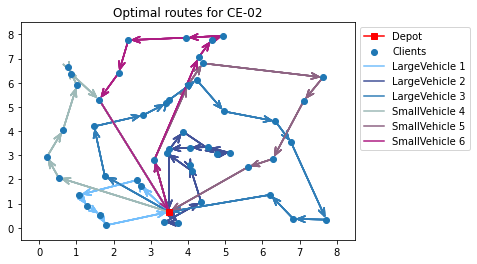

The optimal cost for the distance traveled is: 73.41 €
Route for vehicle k1: 0 -> 43 -> 5 -> 12 -> 38 -> 6 -> 26 -> 0
Route for vehicle k2: 0 -> 30 -> 4 -> 50 -> 20 -> 13 -> 22 -> 33 -> 25 -> 32 -> 44 -> 34 -> 3 -> 0
Route for vehicle k3: 0 -> 28 -> 14 -> 29 -> 45 -> 46 -> 11 -> 10 -> 36 -> 18 -> 40 -> 16 -> 47 -> 0
Route for vehicle k4: 0 -> 21 -> 1 -> 19 -> 24 -> 23 -> 27 -> 31 -> 0
Route for vehicle k5: 0 -> 35 -> 41 -> 2 -> 49 -> 42 -> 15 -> 39 -> 0
Route for vehicle k6: 0 -> 35 -> 48 -> 37 -> 7 -> 17 -> 8 -> 9 -> 31 -> 0
Time to best solution = 3600.157049179077


In [22]:
############ Instance Initialization CE-02 ############
name = "CE-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=50,
                                                                     S1=3,
                                                                     S2=3,
                                                                     Q1=170,
                                                                     dmin=12,
                                                                     dmax=15)
############ model7 Construction ############
model7, x = build_model()

############ model7 Solving ############
model7.reset()
model7.Params.TimeLimit = timelimCE  # Time limit
model7.Params.MIPGap = .15
model7.optimize()

############ Plotting Solution ############
if model7.solcount >= 1:
    # model7.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model7.getAttr('X', x)
    print_route(objective=model7.objVal, edges=selected(vals))
    times.append(model7.runtime)
    print(f"Time to best solution = {model7.runtime}")
    objectives.append(model7.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-03</font>**

Discarded solution information
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.15
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58652 rows, 30720 columns and 233280 nonzeros
Model fingerprint: 0xf3143d93
Variable types: 0 continuous, 30720 integer (29760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 28328 rows and 0 columns
Presolve time: 0.49s
Presolved: 30324 rows, 30720 columns, 175200 nonzeros
Variable types: 0 continuous, 30720 integer (29760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Use crossover to convert LP symmetric solution to basic solution...
Conc

  3392  2986   72.65535  605  476   92.07883   62.36710  32.3%  42.2  209s
  3393  2987   62.64212   21  506   92.07883   62.36710  32.3%  42.2  210s
H 3393  2838                      91.7297977   62.36710  32.0%  42.2  210s
  3400  2842   82.94419  735  427   91.72980   62.36710  32.0%  42.1  215s
  3403  2844   65.87018  127  443   91.72980   62.36710  32.0%  42.1  221s
  3405  2846   63.63298   67  513   91.72980   62.36710  32.0%  42.1  226s
  3407  2847   72.40793  455  539   91.72980   62.36710  32.0%  42.0  230s
  3411  2850   66.69756  354  518   91.72980   62.36710  32.0%  42.0  235s
  3414  2852   88.25960  769  505   91.72980   62.36710  32.0%  42.0  241s
  3418  2854   82.28078  754  531   91.72980   62.45016  31.9%  41.9  245s
H 3420  2712                      89.6920343   62.45284  30.4%  41.9  251s
H 3423  2578                      89.3999488   62.46204  30.1%  41.9  254s
  3424  2578   72.17801  316  710   89.39995   62.48075  30.1%  41.8  255s
  3430  2582   62.60470  

 11139  7047   65.27662   83  403   81.49472   62.85057  22.9%   109  997s
H11296  6920                      80.7538269   62.85057  22.2%   109  997s
 11786  7072   63.41919   29  636   80.75383   62.85597  22.2%   108 1016s
H11805  6876                      79.6485019   62.85597  21.1%   108 1016s
 11951  7110   64.91177   62  417   79.64850   62.85626  21.1%   109 1038s
H12248  7250                      79.2408302   62.85895  20.7%   110 1061s
H12326  7248                      79.2238506   62.85895  20.7%   110 1061s
H12361  7110                      78.6944395   62.85895  20.1%   110 1061s
 12480  7559   71.71854  121  274   78.69444   62.85901  20.1%   110 1087s
 12973  7835   63.68058   57  703   78.69444   62.85901  20.1%   110 1111s
 13261  8161   66.18576  116  495   78.69444   62.86924  20.1%   111 1137s
 13674  8454   63.23855   31  675   78.69444   62.87127  20.1%   112 1164s
 13990  8756   67.46074   84  539   78.69444   62.87190  20.1%   112 1191s
 14324  9153   64.40030  

 21047  9129   66.31272   84 1173   76.02099   62.95626  17.2%   121 3052s
 21049  9131   71.46933  127 1058   76.02099   62.95779  17.2%   121 3065s
 21050  9131   74.34222  207  965   76.02099   62.95966  17.2%   121 3078s
 21051  9132   76.02099  126  958   76.02099   62.96019  17.2%   121 3091s
 21052  9133   63.01771   30  957   76.02099   62.96065  17.2%   121 3104s
 21053  9133   65.51595   85 1068   76.02099   62.96099  17.2%   121 3117s
 21054  9134   63.62126   60 1113   76.02099   62.96103  17.2%   121 3130s
 21055  9135   70.41194  135 1093   76.02099   62.96121  17.2%   121 3142s
 21056  9135   69.30717  168 1014   76.02099   62.96145  17.2%   121 3155s
H21056  8676                      76.0209900   62.96156  17.2%   121 3168s
H21057  8241                      75.8027303   62.96186  16.9%   121 3183s
 21059  8242   63.08755   32 1075   75.80273   62.96194  16.9%   121 3195s
 21060  8243   66.16698   86 1089   75.80273   62.97158  16.9%   121 3209s
 21061  8244   63.92846  

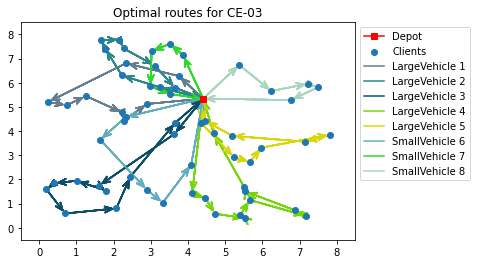

The optimal cost for the distance traveled is: 75.8 €
Route for vehicle k1: 0 -> 41 -> 43 -> 10 -> 35 -> 23 -> 13 -> 20 -> 55 -> 0
Route for vehicle k2: 0 -> 40 -> 48 -> 27 -> 7 -> 42 -> 47 -> 28 -> 11 -> 0
Route for vehicle k3: 0 -> 49 -> 51 -> 39 -> 6 -> 8 -> 16 -> 53 -> 18 -> 26 -> 44 -> 0
Route for vehicle k4: 0 -> 52 -> 17 -> 15 -> 58 -> 14 -> 56 -> 5 -> 45 -> 21 -> 59 -> 46 -> 0
Route for vehicle k5: 0 -> 24 -> 36 -> 1 -> 57 -> 30 -> 4 -> 12 -> 37 -> 0
Route for vehicle k6: 0 -> 2 -> 50 -> 38 -> 19 -> 3 -> 0
Route for vehicle k7: 0 -> 54 -> 22 -> 34 -> 60 -> 9 -> 0
Route for vehicle k8: 0 -> 31 -> 25 -> 32 -> 29 -> 33 -> 0
Time to best solution = 3600.7309646606445


In [23]:
############ Instance Initialization CE-03 ############
name = "CE-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=60,
                                                                     S1=5,
                                                                     S2=3,
                                                                     Q1=140,
                                                                     dmin=12,
                                                                     dmax=15)
############ model8 Construction ############
model8, x = build_model()

############ model8 Solving ############
model8.reset()
model8.Params.TimeLimit = timelimCE  # Time limit
model8.Params.MIPGap = .15
model8.optimize()

############ Plotting Solution ############
if model8.solcount >= 1:
    # model8.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model8.getAttr('X', x)
    print_route(objective=model8.objVal, edges=selected(vals))
    times.append(model8.runtime)
    print(f"Time to best solution = {model8.runtime}")
    objectives.append(model8.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-04</font>**

In [ ]:
############ Instance Initialization CE-04 ############
name = "CE-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=75,
                                                                     S1=3,
                                                                     S2=5,
                                                                     Q1=210,
                                                                     dmin=12,
                                                                     dmax=15)
############ model9 Construction ############
model9, x = build_model()

############ model9 Solving ############
model9.reset()
model9.Params.TimeLimit = timelimCE  # Time limit
model9.optimize()

############ Plotting Solution ############
if model9.solcount >= 1:
    # model9.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model9.getAttr('X', x)
    print_route(objective=model9.objVal, edges=selected(vals))
    times.append(model9.runtime)
    print(f"Time to best solution = {model9.runtime}")
    objectives.append(model9.objVal)
else:
    print("No feasible solution found")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91299 rows, 47400 columns and 362400 nonzeros
Model fingerprint: 0x46578a66
Variable types: 0 continuous, 47400 integer (46200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 44400 rows and 0 columns
Presolve time: 0.71s
Presolved: 46899 rows, 47400 columns, 273000 nonzeros
Variable types: 0 continuous, 47400 integer (46200 binary)
Found heuristic solution: objective 470.8415003

Deterministic concurrent LP optimizer: primal and dual simp

  5160  3719   79.00875  430  724  117.08315   65.65201  43.9%  42.2  321s
  5163  3721  117.08315 1285  568  117.08315   65.74182  43.9%  42.2  325s
  5165  3723   65.81704   38  736  117.08315   65.81704  43.8%  42.2  330s
  5167  3724   68.31718  282  707  117.08315   65.87199  43.7%  42.1  335s
H 5170  3539                     116.3093777   65.91529  43.3%  42.1  343s
H 5170  3361                     115.8276060   65.96092  43.1%  42.1  346s
  5174  3364   72.04654  400  756  115.82761   66.00223  43.0%  42.1  358s
  5175  3364   75.99827  418  807  115.82761   66.00374  43.0%  42.1  361s
  5176  3365   66.01916   10 1035  115.82761   66.01916  43.0%  42.1  366s
  5178  3366   87.45082  727  758  115.82761   66.06566  43.0%  42.1  371s
  5180  3368   70.59938  292  741  115.82761   66.07275  43.0%  42.0  375s
  5184  3370   66.13735   54  835  115.82761   66.13735  42.9%  42.0  380s
  5187  3372   97.10932  744  861  115.82761   66.16662  42.9%  42.0  385s
  5191  3375  109.40432 1

## **<font color="#FBBF44">CE-05</font>**

Discarded solution information
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.25
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 161732 rows, 83200 columns and 644800 nonzeros
Model fingerprint: 0xb59da816
Variable types: 0 continuous, 83200 integer (81600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 79208 rows and 0 columns
Presolve time: 1.58s
Presolved: 82524 rows, 83200 columns, 484000 nonzeros
Variable types: 0 continuous, 83200 integer (81600 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual I

   538   569   74.52246   89  553  155.05715   73.59197  52.5%   129  310s
   577   618   74.91572   92  509  155.05715   73.59197  52.5%   129  317s
   627   671   74.78915  100  489  155.05715   73.59197  52.5%   127  324s
   680   725   74.85982  114  464  155.05715   73.59197  52.5%   123  331s
   734   775   74.90722  125  421  155.05715   73.59197  52.5%   119  339s
   786   819   74.95899  136  424  155.05715   73.59197  52.5%   118  346s
   831   888   75.00510  140  453  155.05715   73.59197  52.5%   119  353s
   905   969   75.35410  150  368  155.05715   73.59197  52.5%   115  361s
   994  1098   75.44757  172  387  155.05715   73.59197  52.5%   111  371s
  1126  1229   75.57772  220  445  155.05715   73.59197  52.5%   104  380s
  1261  1334   75.62945  277  428  155.05715   73.59197  52.5%  97.4  389s
  1367  1497   87.89561  302  380  155.05715   73.59197  52.5%  95.5  399s
  1533  1665   87.98808  360  447  155.05715   73.59197  52.5%  89.4  410s
  1703  1866   88.34540  

  5270  2346  113.95548  584  888  122.72286   75.41095  38.6%  53.5 1275s
  5272  2348  122.72286 1270  989  122.72286   75.41095  38.6%  53.5 1296s
H 5272  2230                     120.5590354   75.41095  37.4%  53.5 1316s
  5277  2233   75.42047   56 1098  120.55904   75.42047  37.4%  53.4 1325s
  5278  2234  100.66241  629  829  120.55904   75.43820  37.4%  53.4 1331s
  5279  2234  119.20712  840  903  120.55904   75.43820  37.4%  53.4 1336s
  5280  2235  101.25587  778  807  120.55904   75.43981  37.4%  53.4 1340s
  5282  2236   75.44851   93 1196  120.55904   75.44851  37.4%  53.4 1346s
  5283  2237   75.45554   64  835  120.55904   75.45554  37.4%  53.4 1352s
  5286  2239  100.51653  422 1213  120.55904   75.46887  37.4%  53.3 1359s
  5287  2240  120.55904 1137 1100  120.55904   75.48739  37.4%  53.3 1365s
  5290  2242   97.18446  383  975  120.55904   75.51985  37.4%  53.3 1371s
  5291  2242  103.23249  452  935  120.55904   75.52168  37.4%  53.3 1377s
  5293  2244  113.95548  

  8898  3531   80.89895  205  627  114.38256   75.63261  33.9%  95.8 2532s
  9183  3778   83.91545  242  501  114.38256   75.63261  33.9%  96.7 2579s
H 9498  3900                     113.6589870   75.63261  33.5%  96.8 2619s
  9669  4090   88.85881  312  504  113.65899   75.63261  33.5%  97.7 2659s
  9880  4295   92.61845  359  525  113.65899   75.63261  33.5%  98.4 2700s
 10168  4496  100.75202  422  430  113.65899   75.63261  33.5%  98.9 2747s
H10333  4496                     113.6489780   75.63261  33.5%  99.0 2747s
 10369  4817  107.38841  515  425  113.64898   75.66376  33.4%  99.0 2804s
 10720  4931   76.07072   44  729  113.64898   75.66376  33.4%  99.5 2842s
H10752  4929                     113.5388536   75.66376  33.4%   100 2842s
H10852  5023                     113.4407649   75.66376  33.3%   100 2878s
 10979  5170   76.84151   56  983  113.44076   75.66376  33.3%   101 2925s
H11039  5169                     113.3100529   75.66376  33.2%   101 2925s
 11137  5411   77.69220  

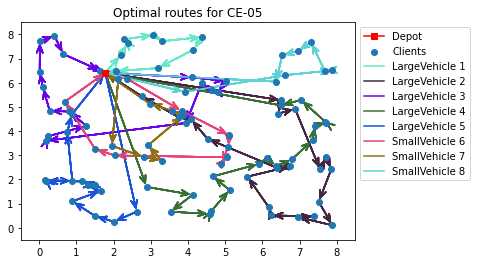

The optimal cost for the distance traveled is: 112.67 €
Route for vehicle k1: 0 -> 15 -> 8 -> 22 -> 85 -> 16 -> 49 -> 7 -> 47 -> 40 -> 0
Route for vehicle k2: 0 -> 48 -> 41 -> 90 -> 80 -> 27 -> 46 -> 79 -> 100 -> 1 -> 43 -> 33 -> 50 -> 32 -> 82 -> 96 -> 59 -> 86 -> 45 -> 83 -> 0
Route for vehicle k3: 0 -> 94 -> 18 -> 20 -> 19 -> 68 -> 77 -> 30 -> 52 -> 13 -> 84 -> 67 -> 89 -> 36 -> 44 -> 70 -> 10 -> 31 -> 0
Route for vehicle k4: 0 -> 66 -> 37 -> 12 -> 98 -> 35 -> 38 -> 78 -> 11 -> 6 -> 74 -> 93 -> 3 -> 62 -> 56 -> 87 -> 14 -> 61 -> 0
Route for vehicle k5: 0 -> 24 -> 55 -> 29 -> 81 -> 2 -> 26 -> 71 -> 25 -> 34 -> 97 -> 54 -> 65 -> 91 -> 0
Route for vehicle k6: 0 -> 17 -> 92 -> 76 -> 60 -> 5 -> 57 -> 23 -> 9 -> 53 -> 0
Route for vehicle k7: 0 -> 21 -> 73 -> 75 -> 99 -> 72 -> 51 -> 95 -> 88 -> 0
Route for vehicle k8: 0 -> 4 -> 64 -> 39 -> 28 -> 63 -> 42 -> 58 -> 69 -> 0
Time to best solution = 3600.2493629455566


In [25]:
############ Instance Initialization CE-05 ############
name = "CE-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=100,
                                                                     S1=5,
                                                                     S2=3,
                                                                     Q1=250,
                                                                     dmin=12,
                                                                     dmax=15)
############ model10 Construction ############
model10, x = build_model()

############ model10 Solving ############
model10.reset()
model10.Params.TimeLimit = timelimCE # Time limit
model10.Params.MIPGap = .25
model10.optimize()

############ Plotting Solution ############
if model10.solcount >= 1:
    # model10.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model10.getAttr('X', x)
    print_route(objective=model10.objVal, edges=selected(vals))
    times.append(model10.runtime)
    print(f"Time to best solution = {model10.runtime}")
    objectives.append(model10.objVal)
else:
    print("No feasible solution found")

# **<font color="#BBBF">G INSTANCES</font>**

## **<font color="#FBBF44">G-01</font>**

Discarded solution information
Set parameter TimeLimit to value 7200
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58208 rows, 29760 columns and 231840 nonzeros
Model fingerprint: 0xe4c8a0d3
Variable types: 0 continuous, 29760 integer (29280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 28682 rows and 120 columns
Presolve time: 0.48s
Presolved: 29526 rows, 29640 columns, 173760 nonzeros
Variable types: 0 continuous, 29640 integer (29280 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.544674e+01, 1298 itera

  2729  1139   71.85134   44  781  117.93971   71.60217  39.3%  36.7  476s
H 2739  1086                     116.9531224   71.60217  38.8%  36.7  480s
  2769  1115   71.91182   48  754  116.95312   71.60217  38.8%  37.5  486s
  2792  1131   71.97617   51  730  116.95312   71.60217  38.8%  38.1  490s
  2835  1155   72.19751   57  742  116.95312   71.60217  38.8%  38.7  496s
  2861  1173   72.45576   60  754  116.95312   71.60217  38.8%  39.4  500s
  2902  1189   72.53195   65  720  116.95312   71.60217  38.8%  40.8  509s
H 2905  1137                     116.8693611   71.60217  38.7%  40.9  509s
  2906  1157   72.52503   65  696  116.86936   71.60217  38.7%  40.9  512s
  2940  1170   72.60842   69  611  116.86936   71.60217  38.7%  42.0  604s
H 2945  1121                     115.7994504   71.60217  38.2%  42.0  604s
H 2947  1075                     105.1964604   71.60217  31.9%  42.2  604s
H 2951  1040                     104.8380537   71.60217  31.7%  42.3  607s
H 2955   997             

 20788 15487   79.38441  137  663   97.24854   71.84011  26.1%  63.2 2555s
 20791 15489   73.27405   68  910   97.24854   71.96508  26.0%  63.1 2560s
 20794 15491   72.90796   44  816   97.24854   71.99880  26.0%  63.1 2571s
 20795 15492   73.80785   58  955   97.24854   72.01137  26.0%  63.1 2607s
 20798 15494   78.22058  144  880   97.24854   72.01780  25.9%  63.1 2631s
 20799 15494   80.75959  155  971   97.24854   72.03865  25.9%  63.1 2669s
 20800 15495   76.52731  114  969   97.24854   72.04369  25.9%  63.1 2670s
 20803 15497   96.70240  169  937   97.24854   72.05517  25.9%  63.1 2694s
 20804 15498   76.41564  115  957   97.24854   72.11849  25.8%  63.1 2729s
 20806 15499   78.71399  192  980   97.24854   72.12173  25.8%  63.1 2747s
H20806 14723                      96.7902088   72.12173  25.5%  63.1 2772s
 20807 14724   92.44549  267  969   96.79021   72.13471  25.5%  63.1 2780s
 20810 14726   81.12986  200  976   96.79021   72.13817  25.5%  63.1 2805s
 20811 14726   86.83255  

 23217  9894   85.35641  286  309   94.36138   72.30382  23.4%  66.1 4978s
 23360  9951   85.36721  302  334   94.36138   72.30382  23.4%  66.2 4995s
 23480 10031   85.38092  319  329   94.36138   72.30382  23.4%  66.3 5013s
 23643 10114   91.06966  343  261   94.36138   72.30382  23.4%  66.5 5033s
H23786  9765                      94.3580392   72.30382  23.4%  66.7 5051s
 23904  9847   86.88021  377  332   94.35804   72.30382  23.4%  66.9 5070s
 24029  9977   86.88467  392  309   94.35804   72.30382  23.4%  67.0 5092s
 24222 10141   91.91531  426  280   94.35804   72.30382  23.4%  67.0 5116s
 24510 10205   92.04792  474  235   94.35804   72.30382  23.4%  66.9 5139s
 24706 10250     cutoff  511        94.35804   72.30382  23.4%  67.2 5160s
 24867 10257   91.48888  540  222   94.35804   72.30382  23.4%  67.4 5206s
 24972 10392   91.50145  564  248   94.35804   72.30382  23.4%  67.5 5229s
 25235 10561     cutoff  608        94.35804   72.31580  23.4%  67.4 5258s
 25535 10592   74.16418  

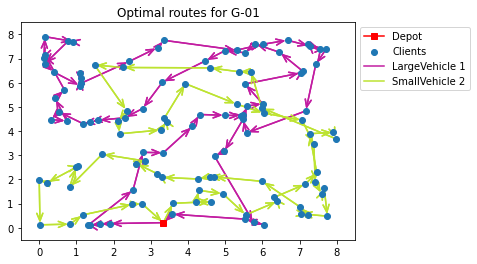

The optimal cost for the distance traveled is: 93.07 €
Route for vehicle k1: 0 -> 95 -> 12 -> 28 -> 75 -> 35 -> 83 -> 16 -> 67 -> 9 -> 105 -> 51 -> 36 -> 59 -> 82 -> 34 -> 13 -> 102 -> 73 -> 79 -> 108 -> 81 -> 17 -> 61 -> 77 -> 48 -> 19 -> 110 -> 4 -> 114 -> 27 -> 5 -> 55 -> 26 -> 120 -> 106 -> 50 -> 90 -> 30 -> 38 -> 64 -> 71 -> 72 -> 111 -> 18 -> 3 -> 74 -> 10 -> 88 -> 78 -> 37 -> 104 -> 96 -> 68 -> 87 -> 107 -> 85 -> 113 -> 11 -> 89 -> 58 -> 1 -> 115 -> 23 -> 45 -> 0
Route for vehicle k2: 0 -> 92 -> 93 -> 101 -> 65 -> 99 -> 62 -> 20 -> 43 -> 25 -> 112 -> 46 -> 40 -> 109 -> 41 -> 118 -> 15 -> 97 -> 42 -> 6 -> 47 -> 53 -> 84 -> 94 -> 86 -> 31 -> 54 -> 66 -> 116 -> 80 -> 117 -> 76 -> 91 -> 32 -> 21 -> 29 -> 70 -> 24 -> 39 -> 69 -> 56 -> 33 -> 63 -> 8 -> 100 -> 103 -> 52 -> 60 -> 119 -> 49 -> 14 -> 2 -> 98 -> 44 -> 57 -> 22 -> 7 -> 0
Time to best solution = 7200.279033660889


In [26]:
############ Instance Initialization G-01 ############
name = "G-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=120,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=800,
                                                                     dmin=5,
                                                                     dmax=10)
############ model11 Construction ############
model11, x = build_model()

############ model11 Solving ############
model11.reset()
model11.Params.TimeLimit = timelimG # Time limit
model5.Params.MIPGap = .20
model11.optimize()

############ Plotting Solution ############
if model11.solcount >= 1:
    # model11.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model11.getAttr('X', x)
    print_route(objective=model11.objVal, edges=selected(vals))
    times.append(model11.runtime)
    print(f"Time to best solution = {model11.runtime}")
    objectives.append(model11.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-02</font>**

Discarded solution information
Set parameter TimeLimit to value 7200
Set parameter MIPGap to value 0.2
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 118592 rows, 60480 columns and 472920 nonzeros
Model fingerprint: 0x36b483bc
Variable types: 0 continuous, 60480 integer (59640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 58383 rows and 0 columns
Presolve time: 1.09s
Presolved: 60209 rows, 60480 columns, 354900 nonzeros
Variable types: 0 continuous, 60480 integer (59640 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual In

H 4892  2531                     146.9013836   86.27351  41.3%  57.9  499s
  4894  2533   86.39847   60 1166  146.90138   86.39847  41.2%  57.9  500s
  4895  2533  133.33297  816 1198  146.90138   86.39854  41.2%  57.9  507s
  4896  2534  133.08034  578  956  146.90138   86.57876  41.1%  57.9  517s
  4899  2536   86.59725   26 1171  146.90138   86.59725  41.1%  57.8  526s
  4900  2537   96.81713  265 1075  146.90138   86.71783  41.0%  57.8  534s
  4901  2537   98.66162  350 1279  146.90138   86.75844  40.9%  57.8  535s
  4902  2538   86.75931    6 1302  146.90138   86.75931  40.9%  57.8  544s
H 4902  2411                     140.9123259   86.75931  38.4%  57.8  553s
H 4902  2289                     138.2559778   86.77565  37.2%  57.8  555s
  4905  2291  132.93604  506 1175  138.25598   86.83467  37.2%  57.8  562s
  4907  2292  133.03440  548 1280  138.25598   86.85419  37.2%  57.7  567s
H 4907  2177                     137.8377639   86.85419  37.0%  57.7  572s
H 4907  2068             

  9064  3827  100.87826  308  643  121.95475   87.19531  28.5%  77.1 1504s
  9266  3977  102.96253  356  502  121.95475   87.19531  28.5%  77.5 1528s
H 9387  3972                     121.7485803   87.19531  28.4%  77.8 1528s
  9428  4207  105.50941  393  368  121.74858   87.19531  28.4%  77.8 1554s
H 9494  4205                     121.5843236   87.19531  28.3%  78.0 1554s
  9701  4436  109.96556  451  312  121.58432   87.19531  28.3%  78.2 1581s
 10004  4707  113.16841  506  346  121.58432   87.19531  28.3%  78.2 1611s
 10361  4995  120.96014  621  214  121.58432   87.19641  28.3%  78.1 1665s
 10690  5158   89.12272   36 1209  121.58432   87.19641  28.3%  78.4 1691s
 10918  5338   89.98752   56  989  121.58432   87.19641  28.3%  78.4 1728s
 11118  5613   91.58714  115  775  121.58432   87.19641  28.3%  78.5 1760s
 11427  5980   97.05790  204  632  121.58432   87.19641  28.3%  78.6 1795s
 11870  6316  111.95204  310  503  121.58432   87.20156  28.3%  78.2 1829s
 12292  6557   87.45781  

 20634  9717   91.05815   83 1506  113.49173   88.18273  22.3%  83.7 5268s
 20635  9718   90.58882   83 1310  113.49173   88.20023  22.3%  83.7 5303s
 20636  9718   88.41666   39 1476  113.49173   88.20023  22.3%  83.7 5331s
 20637  9719   88.35771   54 1352  113.49173   88.20099  22.3%  83.7 5361s
 20640  9721   90.07086   68 1519  113.49173   88.23841  22.3%  83.7 5395s
 20641  9722   91.98205   78 1355  113.49173   88.31876  22.2%  83.7 5433s
 20642  9722   90.96072   83 1610  113.49173   88.31930  22.2%  83.7 5464s
 20643  9723   90.99501   45 1518  113.49173   88.37433  22.1%  83.7 5499s
H20643  9236                     113.4678646   88.37626  22.1%  83.7 5525s
 20645  9237   88.40288   39 1520  113.46786   88.40288  22.1%  83.7 5561s
 20647  9239  111.60923  298 1614  113.46786   88.40656  22.1%  83.7 5592s
H20647  8776                     112.8843832   88.40656  21.7%  83.7 5620s
 20649  8777  104.72975  191 1431  112.88438   88.40822  21.7%  83.7 5651s
H20649  8337             

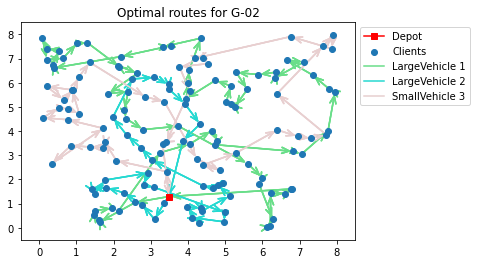

The optimal cost for the distance traveled is: 111.58 €
Route for vehicle k1: 0 -> 71 -> 6 -> 31 -> 14 -> 129 -> 122 -> 9 -> 54 -> 20 -> 37 -> 25 -> 118 -> 16 -> 99 -> 59 -> 58 -> 88 -> 107 -> 74 -> 42 -> 36 -> 78 -> 75 -> 82 -> 121 -> 93 -> 96 -> 127 -> 140 -> 108 -> 17 -> 41 -> 70 -> 105 -> 95 -> 69 -> 125 -> 138 -> 67 -> 57 -> 55 -> 126 -> 1 -> 19 -> 24 -> 38 -> 79 -> 110 -> 5 -> 139 -> 8 -> 133 -> 64 -> 29 -> 30 -> 39 -> 103 -> 92 -> 15 -> 62 -> 47 -> 100 -> 115 -> 18 -> 53 -> 0
Route for vehicle k2: 0 -> 112 -> 83 -> 109 -> 131 -> 26 -> 117 -> 123 -> 106 -> 52 -> 86 -> 73 -> 116 -> 10 -> 13 -> 48 -> 84 -> 50 -> 120 -> 32 -> 61 -> 7 -> 80 -> 2 -> 76 -> 43 -> 128 -> 56 -> 90 -> 35 -> 3 -> 46 -> 119 -> 113 -> 33 -> 0
Route for vehicle k3: 0 -> 22 -> 72 -> 28 -> 94 -> 63 -> 27 -> 91 -> 132 -> 130 -> 77 -> 21 -> 23 -> 12 -> 124 -> 81 -> 51 -> 89 -> 101 -> 98 -> 66 -> 4 -> 11 -> 114 -> 135 -> 97 -> 60 -> 102 -> 111 -> 40 -> 104 -> 49 -> 137 -> 68 -> 136 -> 65 -> 87 -> 44 -> 134 -> 34 ->

In [27]:
############ Instance Initialization G-02 ############
name = "G-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=140,
                                                                     S1=2,
                                                                     S2=1,
                                                                     Q1=560,
                                                                     dmin=5,
                                                                     dmax=10)
############ model12 Construction ############
model12, x = build_model()

############ model12 Solving ############
model12.reset()
model12.Params.TimeLimit = timelimG # Time limit
model12.Params.MIPGap = .20
model12.optimize()

############ Plotting Solution ############
if model12.solcount >= 1:
    # model12.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model12.getAttr('X', x)
    print_route(objective=model12.objVal, edges=selected(vals))
    times.append(model12.runtime)
    print(f"Time to best solution = {model12.runtime}")
    objectives.append(model12.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-03</font>**

Discarded solution information
Set parameter TimeLimit to value 7200
Set parameter MIPGap to value 0.3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 206256 rows, 104960 columns and 823040 nonzeros
Model fingerprint: 0xae36c945
Variable types: 0 continuous, 104960 integer (103680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 101764 rows and 0 columns
Presolve time: 1.94s
Presolved: 104492 rows, 104960 columns, 617600 nonzeros
Variable types: 0 continuous, 104960 integer (103680 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.   

  3956  3717  127.18956  471  399          -   87.60754      -   111  574s
  4393  4058  137.70794  527  381          -   87.60754      -   103  588s
  4818  4422  143.40778  572  368          -   87.60754      -  96.9  605s
  5275  4423  125.04907  512 1133          -   87.60754      -  91.6  631s
  5277  4424   88.57044  116 1168          -   87.60754      -  91.6  711s
  5278  4425  165.58276  957 1169          -   87.60754      -  91.6  720s
  5282  4428   88.12957   70 1092          -   87.60754      -  91.5  725s
  5283  4428  179.16503  995 1088          -   87.60754      -  91.5  751s
  5284  4429   87.60754   55  977          -   87.60754      -  91.5  759s
  5285  4430   88.18182   90 1210          -   87.60754      -  91.4  760s
  5286  4430   91.44822  293 1162          -   87.60754      -  91.4  786s
  5287  4431   88.13302  234 1134          -   87.93016      -  91.4  796s
  5291  4434  103.74030  243 1201          -   88.02450      -  91.3  812s
  5292  4434  103.01076  

H 6545  3412                     245.9941845   90.40955  63.2%  35.7 2030s
  6546  3450   94.90522  180  695  245.99418   90.40955  63.2%  35.7 2045s
H 6586  3335                     237.5991319   90.40955  61.9%  37.2 2060s
H 6596  3204                     235.1709821   90.40955  61.6%  37.6 2060s
  6628  3240   94.93381  193  792  235.17098   90.40955  61.6%  39.0 2078s
H 6687  3099                     229.5314327   90.40955  60.6%  40.2 2078s
  6693  3145   94.94251  199  723  229.53143   90.40955  60.6%  40.4 2102s
H 6723  3020                     221.5280873   90.40955  59.2%  41.0 2102s
  6756  3069   98.78720  204  716  221.52809   90.40955  59.2%  41.8 2119s
H 6831  2984                     213.0492876   90.40955  57.6%  43.1 2147s
  6896  3014   98.91818  217  673  213.04929   90.40955  57.6%  44.2 2173s
H 6904  2907                     211.8871782   90.40955  57.3%  44.5 2173s
H 6932  2799                     211.3802540   90.40955  57.2%  44.9 2173s
H 6941  2702             

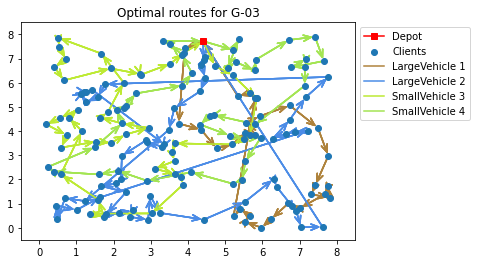

The optimal cost for the distance traveled is: 135.1 €
Route for vehicle k1: 0 -> 107 -> 41 -> 105 -> 74 -> 12 -> 136 -> 90 -> 144 -> 142 -> 92 -> 29 -> 68 -> 108 -> 95 -> 30 -> 156 -> 131 -> 152 -> 104 -> 133 -> 25 -> 57 -> 58 -> 86 -> 14 -> 36 -> 101 -> 1 -> 61 -> 0
Route for vehicle k2: 0 -> 98 -> 37 -> 24 -> 17 -> 85 -> 49 -> 127 -> 153 -> 53 -> 66 -> 129 -> 6 -> 50 -> 32 -> 45 -> 160 -> 102 -> 145 -> 137 -> 103 -> 27 -> 99 -> 143 -> 149 -> 78 -> 23 -> 113 -> 151 -> 118 -> 38 -> 147 -> 48 -> 124 -> 18 -> 7 -> 43 -> 39 -> 42 -> 150 -> 26 -> 97 -> 60 -> 40 -> 81 -> 70 -> 109 -> 155 -> 140 -> 154 -> 83 -> 0
Route for vehicle k3: 0 -> 15 -> 122 -> 121 -> 56 -> 12 -> 44 -> 65 -> 111 -> 28 -> 11 -> 73 -> 54 -> 34 -> 134 -> 112 -> 77 -> 76 -> 117 -> 79 -> 80 -> 128 -> 16 -> 35 -> 114 -> 100 -> 67 -> 2 -> 157 -> 13 -> 158 -> 69 -> 20 -> 120 -> 139 -> 75 -> 106 -> 8 -> 130 -> 159 -> 62 -> 138 -> 9 -> 110 -> 0
Route for vehicle k4: 0 -> 125 -> 31 -> 96 -> 94 -> 72 -> 146 -> 89 -> 88 -> 126 -

In [28]:
############ Instance Initialization G-03 ############
name = "G-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=160,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=650,
                                                                     dmin=5,
                                                                     dmax=10)
############ model13 Construction ############
model13, x = build_model()

############ model13 Solving ############
model13.reset()
model13.Params.TimeLimit = timelimG  # Time limit
model13.Params.MIPGap = .30
model13.optimize()

############ Plotting Solution ############
if model13.solcount >= 1:
    # model13.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model13.getAttr('X', x)
    print_route(objective=model13.objVal, edges=selected(vals))
    times.append(model13.runtime)
    print(f"Time to best solution = {model13.runtime}")
    objectives.append(model13.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-04</font>**

Discarded solution information
Set parameter TimeLimit to value 7200
Set parameter MIPGap to value 0.3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 260836 rows, 132480 columns and 1041120 nonzeros
Model fingerprint: 0x09886203
Variable types: 0 continuous, 132480 integer (131040 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [8e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 128884 rows and 0 columns
Presolve time: 2.35s
Presolved: 131952 rows, 132480 columns, 781200 nonzeros
Variable types: 0 continuous, 132480 integer (131040 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.  

  1811  1840  105.14122  287  649          -  102.46071      -   200  751s
  1901  1967  105.40045  302  615          -  102.46071      -   203  799s
  2071  2173  106.90817  314  599          -  102.46071      -   194  827s
  2342  2398  115.33321  361  500          -  102.46071      -   179  856s
  2650  2701  135.27684  413  381          -  102.46071      -   167  885s
  3010  3034  156.89296  495  376          -  102.46071      -   154  909s
  3399  3360  178.42319  565  252          -  102.46071      -   141  929s
  3774  3658  204.52485  644  163          -  102.46071      -   130  947s
  4158  3954  216.69076  721  214          -  102.46071      -   121  964s
  4534  4250  232.55192  802  146          -  102.46071      -   113  982s
  4905  4319  246.98320  888  149          -  102.46071      -   106 1086s
  4985  4651  247.81514  902  123          -  102.46071      -   105 1103s
  5389  4652  103.70446  228 1308          -  102.46071      -  99.3 1140s
  5391  4653  228.25852  

  5885  2832  104.82126   76  915  368.71649  104.34726  71.7%   108 3258s
  5910  2843  104.85250   78  949  368.71649  104.34726  71.7%   108 3268s
  5932  2859 infeasible   80       368.71649  104.34726  71.7%   108 3280s
  5960  2871  105.31964   83  812  368.71649  104.34726  71.7%   109 3291s
  5987  2889  105.33124   85  876  368.71649  104.34726  71.7%   109 3302s
  6017  2911  105.45939   88  914  368.71649  104.34726  71.7%   109 3315s
  6051  2924  105.91250   90  788  368.71649  104.34726  71.7%   110 3327s
  6077  2936  106.75193   92  915  368.71649  104.34726  71.7%   110 3341s
  6099  2949  106.56451   95  951  368.71649  104.34726  71.7%   111 3354s
  6122  2967  106.56650   97  913  368.71649  104.34726  71.7%   111 3367s
  6149  2980  106.57229  101  964  368.71649  104.34726  71.7%   112 3386s
  6174  2996  106.69154  103  938  368.71649  104.34726  71.7%   112 3401s
  6201  3014  106.69250  105  940  368.71649  104.34726  71.7%   113 3418s
  6230  3027  106.71931  

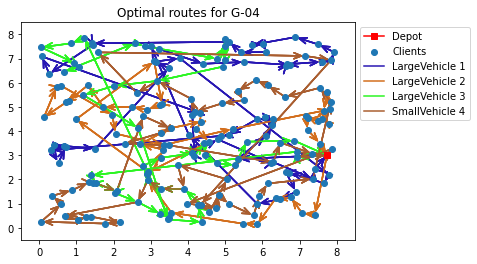

The optimal cost for the distance traveled is: 201.22 €
Route for vehicle k1: 0 -> 90 -> 121 -> 141 -> 114 -> 156 -> 28 -> 173 -> 112 -> 125 -> 74 -> 154 -> 80 -> 67 -> 95 -> 9 -> 97 -> 96 -> 124 -> 19 -> 161 -> 155 -> 12 -> 167 -> 107 -> 45 -> 44 -> 38 -> 145 -> 157 -> 85 -> 58 -> 153 -> 21 -> 123 -> 149 -> 31 -> 65 -> 3 -> 122 -> 148 -> 108 -> 37 -> 43 -> 146 -> 128 -> 16 -> 75 -> 83 -> 32 -> 72 -> 26 -> 10 -> 22 -> 165 -> 143 -> 0
Route for vehicle k2: 0 -> 89 -> 172 -> 64 -> 115 -> 70 -> 82 -> 159 -> 92 -> 59 -> 158 -> 132 -> 35 -> 30 -> 84 -> 160 -> 113 -> 17 -> 101 -> 61 -> 78 -> 179 -> 5 -> 14 -> 137 -> 169 -> 126 -> 111 -> 150 -> 69 -> 178 -> 102 -> 39 -> 6 -> 166 -> 174 -> 2 -> 134 -> 60 -> 164 -> 50 -> 103 -> 117 -> 0
Route for vehicle k3: 0 -> 93 -> 23 -> 24 -> 53 -> 55 -> 100 -> 47 -> 62 -> 140 -> 20 -> 175 -> 33 -> 7 -> 180 -> 151 -> 106 -> 163 -> 142 -> 68 -> 105 -> 41 -> 49 -> 98 -> 40 -> 8 -> 91 -> 177 -> 57 -> 1 -> 130 -> 63 -> 86 -> 29 -> 92 -> 51 -> 110 -> 116 -> 72 

In [29]:
############ Instance Initialization G-04 ############
name = "G-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=180,
                                                                     S1=3,
                                                                     S2=1,
                                                                     Q1=600,
                                                                     dmin=5,
                                                                     dmax=10)
############ model14 Construction ############
model14, x = build_model()

############ model14 Solving ############
model14.reset()
model14.Params.TimeLimit = timelimG # Time limit
model14.Params.MIPGap = .30
model14.optimize()

############ Plotting Solution ############
if model14.solcount >= 1:
    # model14.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model14.getAttr('X', x)
    print_route(objective=model14.objVal, edges=selected(vals))
    times.append(model14.runtime)
    print(f"Time to best solution = {model14.runtime}")
    objectives.append(model14.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-05</font>**

Discarded solution information
Set parameter TimeLimit to value 7200
Set parameter MIPGap to value 0.3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402220 rows, 204000 columns and 1606000 nonzeros
Model fingerprint: 0x29698ae4
Variable types: 0 continuous, 204000 integer (202000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 199005 rows and 0 columns (presolve time = 5s) ...
Presolve removed 199005 rows and 0 columns
Presolve time: 5.12s
Presolved: 203215 rows, 204000 columns, 1205000 nonzeros
Variable types: 0 continuous, 204000 integer (202000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only

   630   658  106.70906   91 1335          -  106.11409      -   110  655s
   657   670  106.64324   92 1269          -  106.11409      -   110  667s
   669   683  106.64531   94 1290          -  106.11409      -   114  678s
   682   700  106.71079   96 1244          -  106.11409      -   118  690s
   699   719  106.72423   98 1298          -  106.11409      -   121  703s
   718   738  106.73033  102 1295          -  106.11409      -   125  714s
   737   754  106.74155  103 1195          -  106.11409      -   128  725s
   753   780  106.74155  104 1202          -  106.11409      -   130  738s
   779   803  106.75495  107 1229          -  106.11409      -   132  753s
   802   819  106.74580  108 1272          -  106.11409      -   135  764s
   818   840  106.75177  113 1166          -  106.11409      -   138  782s
   839   868  106.75364  115 1121          -  106.11409      -   141  797s
   867   892  106.75921  121 1109          -  106.11409      -   143  813s
   891   918  106.76954  

  5227  4709  172.45903  657 1736          -  109.33703      -   195 3553s
  5228  4710  148.66856  581 2210          -  109.34550      -   195 3556s
  5230  4711  119.52961  508 2366          -  109.36712      -   195 3560s
  5231  4712  109.64985  481 2395          -  109.36712      -   195 3576s
  5232  4712  165.47382  626 1859          -  109.41194      -   195 3598s
  5233  4713  152.64121  592 2233          -  109.41953      -   195 3600s
  5235  4714  170.37626  890 2321          -  109.42137      -   194 3618s
  5236  4715  128.02633  677 1885          -  109.48589      -   194 3644s
  5237  4716  146.01922  831 1874          -  109.49237      -   194 3646s
  5238  4716  109.49267  500 1975          -  109.49267      -   194 3661s
  5239  4717  109.53536  377 1714          -  109.53536      -   194 3683s
  5240  4718  109.53917   90 2600          -  109.53917      -   194 3686s
  5241  4718  109.54140  130 2428          -  109.54140      -   194 3692s
  5242  4719  134.79776  

  5437  4857  110.20881   36 1916          -  109.97571      -  27.3 6653s
  5444  4864  110.23043   37 1292          -  109.97571      -  28.1 6666s
  5453  4872  110.23029   38 1528          -  109.97571      -  28.5 6681s
  5464  4878  110.25888   40 1485          -  109.97571      -  29.1 6697s
H 5474  4642                     869.9242618  109.97571  87.4%  29.6 6771s
H 5481  4416                     541.0973502  109.97571  79.7%  30.0 7023s
H 5482  4199                     533.4784228  109.97571  79.4%  30.1 7023s
  5485  4216  110.29014   42 1471  533.47842  109.97571  79.4%  30.2 7055s
  5503  4221  110.32125   44 1260  533.47842  109.97571  79.4%  30.9 7083s
H 5514  4016                     471.7696144  109.97571  76.7%  31.8 7200s

Cutting planes:
  Gomory: 114
  Implied bound: 336
  Projected implied bound: 1
  Clique: 18
  MIR: 106
  StrongCG: 24
  Flow cover: 353
  Zero half: 448
  RLT: 18
  Relax-and-lift: 148

Explored 5518 nodes (1210086 simplex iterations) in 7201.05 se

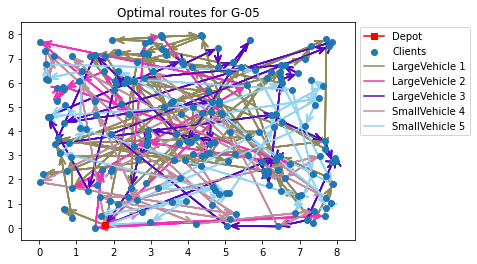

The optimal cost for the distance traveled is: 471.77 €
Route for vehicle k1: 0 -> 136 -> 91 -> 199 -> 102 -> 7 -> 86 -> 163 -> 141 -> 148 -> 159 -> 63 -> 84 -> 121 -> 11 -> 38 -> 195 -> 129 -> 140 -> 21 -> 127 -> 22 -> 59 -> 108 -> 150 -> 56 -> 137 -> 61 -> 1 -> 94 -> 124 -> 198 -> 16 -> 178 -> 200 -> 45 -> 183 -> 197 -> 196 -> 107 -> 184 -> 41 -> 191 -> 35 -> 188 -> 160 -> 176 -> 9 -> 185 -> 60 -> 64 -> 170 -> 134 -> 104 -> 4 -> 157 -> 6 -> 131 -> 161 -> 12 -> 81 -> 151 -> 105 -> 138 -> 72 -> 65 -> 89 -> 87 -> 75 -> 187 -> 162 -> 149 -> 68 -> 174 -> 190 -> 145 -> 28 -> 99 -> 173 -> 112 -> 0
Route for vehicle k2: 0 -> 164 -> 29 -> 167 -> 139 -> 81 -> 32 -> 36 -> 181 -> 15 -> 55 -> 172 -> 180 -> 125 -> 144 -> 130 -> 10 -> 82 -> 128 -> 175 -> 194 -> 110 -> 5 -> 0
Route for vehicle k3: 0 -> 96 -> 74 -> 169 -> 170 -> 122 -> 118 -> 50 -> 132 -> 42 -> 48 -> 23 -> 147 -> 22 -> 40 -> 55 -> 26 -> 52 -> 92 -> 51 -> 20 -> 185 -> 154 -> 120 -> 166 -> 9 -> 102 -> 69 -> 58 -> 87 -> 39 -> 186 -> 171

In [30]:
############ Instance Initialization G-05 ############
name = "G-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=200,
                                                                     S1=3,
                                                                     S2=2,
                                                                     Q1=585,
                                                                     dmin=5,
                                                                     dmax=10)
############ model15 Construction ############
model15, x = build_model()

############ model15 Solving ############
model15.reset()
model15.Params.TimeLimit = timelimG  # Time limit
model15.Params.MIPGap = .30
model15.optimize()

############ Plotting Solution ############
if model15.solcount >= 1:
    # model15.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model15.getAttr('X', x)
    print_route(objective=model15.objVal, edges=selected(vals))
    times.append(model15.runtime)
    print(f"Time to best solution = {model15.runtime}")
    objectives.append(model15.objVal)
else:
    print("No feasible solution found")

# **<font color="#BBBF">Plotting results</font>**

In [8]:
# Runtime results
times_1stSolution = [
    0.0129525146484375,
    0.01496124267578125,
    0.06981086730957031,
    0.04587745666503906,
    0.08788490295410156,
    0.7049407958984375,
    0.396087646484375,
    1.4575767517089844,
    1.27703857421875,
    10.33984375,
    23.35746955871582,
    143.83235931396484,
    1234.250093460083,
    2782.9001121520996, 
    4954.151718139648]

times_bestSolution = [
    0.04388618469238281,
    0.3703422546386719,
    8.246297836303711,
    680.0794353485107,
    1093.8382225036621, 
    771.6032619476318,
    2736.157049179077,
    3183.7309646606445,
    3442.1439895629883,
    3564.2493629455566,
    6627.279033660889,
    6517.80567741394,
    6224.256128311157,
    7157.11431312561,
    7201.072872161865]

# Objectives results
objectives_1stSolution = [
    39.50361808252076,
    57.83661482379392,
    64.91037122564715,
    124.8183372157811,
    187.68773168539238,
    109.29472585051663,
    289.11165656392,
    367.39009072838877,
    470.8415002948603,
    551.7259686320184,
    469.1066575737234,
    261.50408936881604,
    660.23239584534523,
    1027.2057230572934,
    864.971618409769]

objectives_bestSolution = [
    22.55508482497172,
    29.196976063608044,
    33.24195613211528,
    35.864904130331205,
    49.56598818246004,
    42.868446885983374,
    73.41027767452577,
    75.80273030509582,
    106.75627022933315,
    112.66963723060917,
    93.06594035811467,
    111.57691844865784,
    135.09672962848188,
    201.22478741663983,
    471.76961441535343]

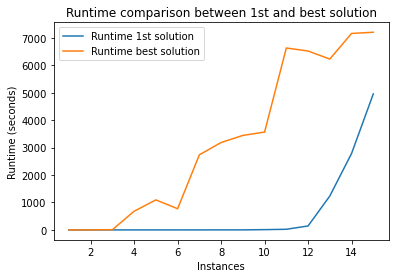

In [9]:
plt.plot(range(1,16), times_1stSolution, label="Runtime 1st solution")
plt.plot(range(1,16), times_bestSolution, label="Runtime best solution")
plt.title("Runtime comparison between 1st and best solution")
plt.legend(loc='best')
plt.xlabel("Instances")
plt.ylabel("Runtime (seconds)")
plt.savefig("FigXX-RuntimeComparison.png", bbox_inches='tight', dpi=600)
plt.show()

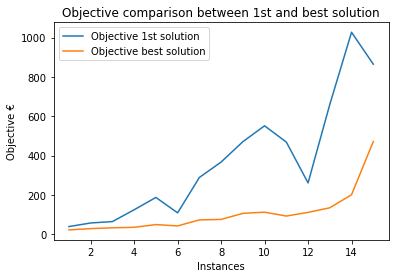

In [10]:
plt.plot(range(1,16), objectives_1stSolution, label="Objective 1st solution")
plt.plot(range(1,16), objectives_bestSolution, label="Objective best solution")
plt.title("Objective comparison between 1st and best solution")
plt.legend(loc='best')
plt.xlabel("Instances")
plt.ylabel("Objective €")
plt.savefig("FigXX-ObjectiveComparison.png", bbox_inches='tight', dpi=600)
plt.show()